In [8]:
import pandas as pd
import numpy as np
import sys
import yaml
import os

import plotly.io as pio
import plotly.graph_objects as go
pio.templates.default = "simple_white"
from plotly.subplots import make_subplots

import fig_utils
import load_datasets

In [9]:
# load configuration file

basedir = 'configuration_files'
dataset_path = os.path.join('dataset_configs','matbench_expt_gap.yaml')
sl_path = os.path.join('sl_configs','1.yaml')

with open(os.path.join(basedir,dataset_path)) as file:
    sl_config = yaml.load(file, Loader=yaml.FullLoader)

with open(os.path.join(basedir,sl_path)) as file:
    sl_config.update(yaml.load(file, Loader=yaml.FullLoader))

print(sl_config)


{'dataset': 'matbench_expt_gap', 'output': 'gap expt', 'categoricals': None, 'config_id': 1, 'n_sample': 0, 'n_training': 50, 'iterations': 100, 'trials': 100, 'batch': 1, 'discovery_break_number': 0, 'poi': None, 'holdout_fraction': 0.1, 'targets': [[0, 10]]}


In [5]:
df = load_datasets.get_matbench_dataset(sl_config['dataset'], sl_config['output'])
df = load_datasets.featurize_composition(df, sl_config['output'])
df = load_datasets.group_and_index_formula(df, None, sl_config['output'])

StrToComposition:   0%|          | 0/2154 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/2154 [00:00<?, ?it/s]

In [6]:
# 10% of dataset is held out as test set
holdout = int(0.1*len(df))
df = df.sample(len(df)-holdout)

target_min_quantile = 0.9  ## [90,100]

# 50 training points are randomly sampled from compounds outside target window
df_training_pool = df[df[sl_config['output']]<df[sl_config['output']].quantile(target_min_quantile)]
df_training = df_training_pool.sample(50)

# compounds in target window
df_target = df[df[sl_config['output']]>=df[sl_config['output']].quantile(0.9)]

# candidate pool = compounds in training pool not selected for training + compounds in target window
df_pool = pd.concat([df_training_pool.drop(df_training.index), df_target])

print('Total compounds (test set removed): {}'.format(len(df)))
print('Training points: {}'.format(len(df_training)))
print('Total targets: {}'.format(len(df_target)))
print('Total compounds in pool: {}'.format(len(df_pool)))


Total compounds (test set removed): 1939
Training points: 50
Total targets: 194
Total compounds in pool: 1889


This is the format of your plot grid:
⎡ (1,1) x,y   ⎤  [ (1,2) x2,y2 ]
⎣      :      ⎦  [ (2,2) x3,y3 ]



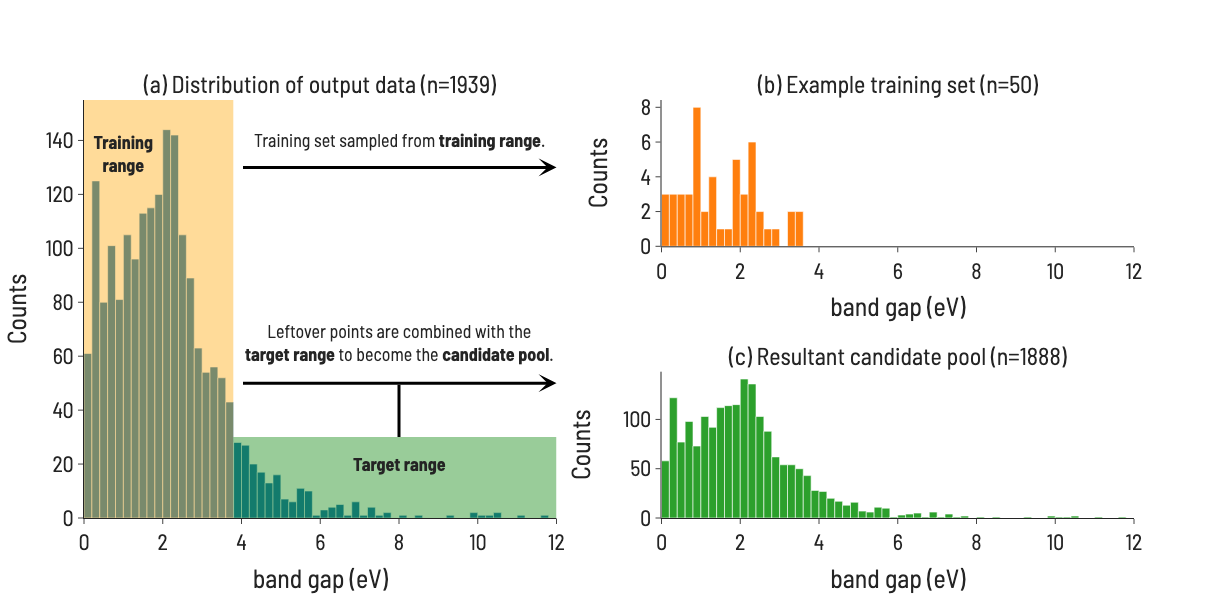

In [10]:
fig = go.Figure()
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'rowspan':2}, {}],
          [None,{}]],
    print_grid=True,
        vertical_spacing=0.3,
    subplot_titles=['(a) Distribution of output data (n={})'.format(len(df)), 
                    '(b) Example training set (n={})'.format(len(df_training)), 
                    '(c) Resultant candidate pool (n=1888)'.format(len(df_pool))]
)
fig.add_trace(go.Histogram(x=df[sl_config['output']], nbinsx=100), row=1, col=1)
fig.add_trace(go.Histogram(x=df_training[sl_config['output']], nbinsx=25), row=1, col=2)
fig.add_trace(go.Histogram(x=df_pool[sl_config['output']], nbinsx=100), row=2, col=2)

fig.add_shape(type="rect", x0=0, x1=df[sl_config['output']].quantile(0.9), y0=0, y1=155, line_color="orange", fillcolor="orange", row=1, col=1)
fig.add_shape(type="rect", x0=df[sl_config['output']].quantile(0.9), x1=12, y0=0, y1=30, line_color="green", fillcolor="green", row=1, col=1)
fig.update_shapes(opacity=0.4, xref="x", yref="y")
fig.add_annotation(
  x=12,  # arrows' head
  y=130,  # arrows' head
  ax=4,  # arrows' tail
  ay=130,  # arrows' tail
  xref='x',
  yref='y',
  axref='x',
  ayref='y',
  text='',  # if you want only the arrow
  showarrow=True,
  arrowhead=3,
  arrowsize=1,
  arrowwidth=3,
  arrowcolor='black',
    row=1,
    col=1
)

fig.add_annotation(
  x=12,
  y=50, 
  ax=4,
  ay=50,  
  xref='x',
  yref='y',
  axref='x',
  ayref='y',
  text='',
  showarrow=True,
  arrowhead=3,
  arrowsize=1,
  arrowwidth=3,
  arrowcolor='black',
    row=1,
    col=1
)

fig.add_annotation(
  x=8,
  y=30,
  ax=8,
  ay=50,
  xref='x',
  yref='y',
  axref='x',
  ayref='y',
  text='',
  showarrow=True,
  arrowhead=0,
  arrowsize=1,
  arrowwidth=3,
  arrowcolor='black',
    row=1,
    col=1
)

fig.update_xaxes(range=[0, 12], title_text='band gap (eV)', row=1, col=1)
fig.update_xaxes(range=[0, 12], title_text='band gap (eV)', row=1, col=2)
fig.update_xaxes(range=[0, 12], title_text='band gap (eV)', row=2, col=2)
fig.update_yaxes(title_text='Counts', row=1, col=1)
fig.update_yaxes(title_text='Counts', row=1, col=2)
fig.update_yaxes(title_text='Counts', row=2, col=2)


# updates subplot titles
fig.update_annotations(font=dict(family="Barlow Semi Condensed", size=24))
fig.update_layout(font=dict(family="Barlow Semi Condensed", size=22), width=1200, height=600,  showlegend=False)

fig.add_annotation(
  x=8, 
  y=140,  
  ax=11,  
  ay=60,  
  xref='x',
  yref='y',
  axref='x',
  ayref='y',
    font=dict(size=18),
  showarrow=False,
    text='Training set sampled from <b>training range</b>.',
    row=1,
    col=1
)

fig.add_annotation(
  x=8, 
  y=65,  
  ax=11,  
  ay=60,  
  xref='x',
  yref='y',
  axref='x',
  ayref='y',
    font=dict(size=18),
  showarrow=False,
    text='Leftover points are combined with the<br><b>target range</b> to become the <b>candidate pool</b>.',
    row=1,
    col=1
)

fig.add_annotation(
    x=1,
    y=135, 
    ax=150, 
    ay=150, 
    xref='x',
    yref='y',
    axref='x',
    ayref='y',
    font=dict(size=18),
    showarrow=False,
    text='<b> Training <br>range</b>',
    row=1,
    col=1
)

fig.add_annotation(
  x=8,
  y=20, 
  ax=150,  
  ay=150,  
  xref='x',
  yref='y',
  axref='x',
  ayref='y',
    font=dict(size=18),
  showarrow=False,
    text='<b>Target range</b>',
    row=1,
    col=1
)


fig.show()
fig.write_image(os.path.join("static","fig2-data_config-matbench_expt_gap.png"), scale=2)
